In [1]:
pip install hpelm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 10.5 MB/s eta 0:00:00


In [2]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=067dfb7f527aac2188cb17a8abfac4b062b16f0df9b349654d6bc6c8909df04e
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [3]:
pip install mapie

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 kB 4.0 MB/s eta 0:00:00


In [4]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.3 MB/s eta 0:00:00


✅ Data shape: (1846590, 18)

📘 X_train_scaled:
        BVP       EDA      TEMP         X         Y         Z        HR  \
0 -0.471120 -0.659270  0.258455 -0.002032 -0.605395  0.756258 -0.807135   
1 -0.087365 -0.674260  0.050494 -1.164615 -0.097261 -0.545259 -0.538412   
2  0.013315  0.858887  1.228937  0.742022  0.254524  1.123352  1.098095   
3  0.212290 -0.700028 -0.189460  0.369995 -1.973448 -0.311654 -0.915398   
4  0.038024  0.059074  0.290449  1.579082  1.153531  1.023235 -0.364418   

      Delta     Theta    Alpha1    Alpha2     Beta1     Beta2    Gamma1  \
0  1.699961 -0.688622  1.249073 -0.587974 -0.725217  0.883266 -0.709403   
1  0.390992 -0.660252 -0.725355 -0.263095 -0.722949 -0.711458 -0.475862   
2 -0.690126 -0.683329 -0.127544 -0.660055  0.054753  0.033733 -0.605752   
3  2.078938 -0.286534  1.287965  1.230047  0.011405  1.768263 -0.673554   
4  0.645086  0.776228 -0.691491  1.234611  1.320024  1.267352 -0.716893   

     Gamma2  Attention  Meditation  
0  2.532636   

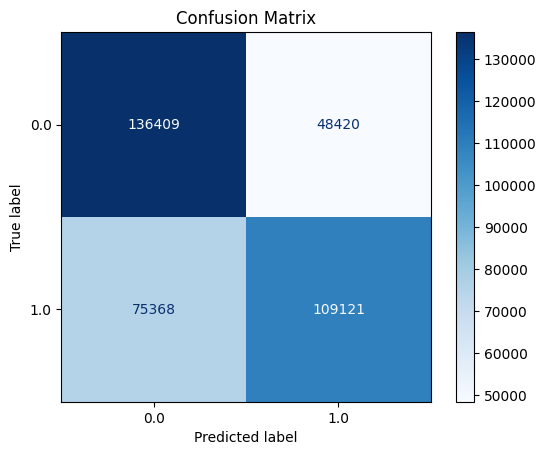

   Sample  Predicted_Class  Uncertainty (1 - max prob)
0       0              1.0                    0.370879
1       1              0.0                    0.002553
2       2              0.0                    0.366671
3       3              1.0                    0.433223
4       4              0.0                    0.497624


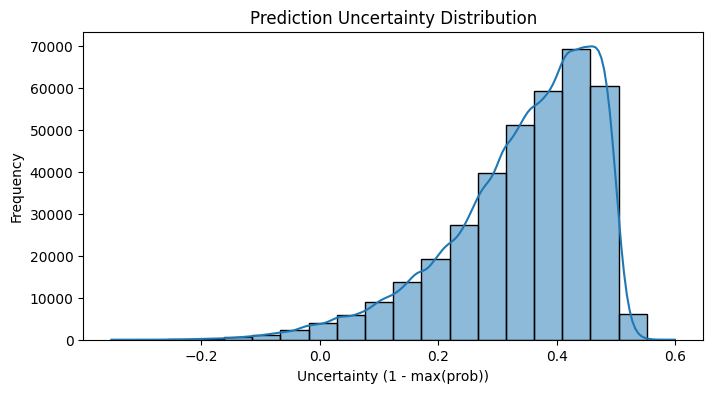

 96%|=================== | 192/200 [00:22<00:00]       

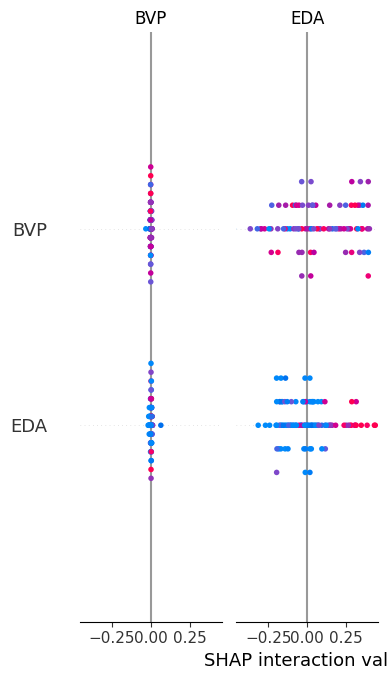

🟡 LIME Explanation for First Sample:
[('TEMP > 0.75', 0.13002073753788712), ('HR > 0.58', -0.10162086142228594), ('-0.65 < EDA <= -0.43', -0.08492548078446933), ('Y <= -0.53', 0.03380670531664516), ('-0.38 < Gamma2 <= 0.23', -0.015211258794231495), ('0.03 < BVP <= 0.33', 0.014984198218424982), ('-0.39 < Beta1 <= 0.26', 0.01044076105494458), ('Gamma1 <= -0.65', -0.009702842561345681), ('Theta <= -0.62', 0.008788739034084407), ('-0.66 < Alpha1 <= -0.37', 0.0066796771257506)]
✅ Results saved to 'ELM_Model_Results.xlsx'


In [8]:
# elm_uncertainty_xai.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from lime.lime_tabular import LimeTabularExplainer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, confusion_matrix, classification_report,
    ConfusionMatrixDisplay
)

from hpelm import ELM
import warnings
warnings.filterwarnings("ignore")


def compute_uncertainty(probs):
    """Return uncertainty as 1 - max(probability) for each sample."""
    return 1 - np.max(probs, axis=1)


def main():
    # === Load Dataset ===
    # Please update the file path below to your actual CSV file and ensure it contains a 'class' column.
    try:
        data = pd.read_csv("/content/drive/MyDrive/CODE/Prince Okyere/UP/MEFAR_UP.csv")  # Update with your actual file path
        data.dropna(inplace=True)
        print("✅ Data shape:", data.shape)

        # Check if the DataFrame is empty after loading and dropping NaNs
        if data.empty:
            print("❌ DataFrame is empty after loading and dropping NaN values. Please check your file path and data.")
            return

        # === Encode Class Column ===
        label_encoder = LabelEncoder()
        data['class'] = label_encoder.fit_transform(data['class'])
        classes = label_encoder.classes_.astype(str)

        X = data.drop('class', axis=1)
        y = data['class']
        encoder = OneHotEncoder()
        y_encoded = encoder.fit_transform(y.values.reshape(-1, 1)).toarray()

        # === Train/Test Split ===
        X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
        y_train_class = np.argmax(y_train, axis=1)
        y_test_class = np.argmax(y_test, axis=1)

        # === Scaling ===
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # === ELM Training ===
        elm = ELM(X_train_scaled.shape[1], y_train.shape[1])
        elm.add_neurons(50, "sigm")
        elm.add_neurons(50, "tanh")
        elm.add_neurons(y_train.shape[1], "sigm")
        elm.train(X_train_scaled, y_train)

        y_pred_prob = elm.predict(X_test_scaled)
        y_pred = (y_pred_prob > 0.5).astype(int)
        y_pred_class = np.argmax(y_pred, axis=1)


            # === Display Arrays as DataFrames ===
        X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
        X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)
        y_pred_class_df = pd.DataFrame({"Predicted Class": label_encoder.inverse_transform(y_pred_class)})
        y_pred_prob_df = pd.DataFrame(y_pred_prob, columns=[f"Class_{cls}" for cls in classes])

        print("\n📘 X_train_scaled:")
        print(X_train_df.head())

        print("\n📗 X_test_scaled:")
        print(X_test_df.head())

        print("\n📙 Predicted Classes:")
        print(y_pred_class_df.head())

        print("\n📕 Predicted Probabilities:")
        print(y_pred_prob_df.head())


        # === Evaluation ===
        acc = accuracy_score(y_test_class, y_pred_class)
        prec = precision_score(y_test_class, y_pred_class, average='weighted')
        rec = recall_score(y_test_class, y_pred_class, average='weighted')
        f1 = f1_score(y_test_class, y_pred_class, average='weighted')
        mcc = matthews_corrcoef(y_test_class, y_pred_class)
        report = classification_report(y_test_class, y_pred_class, target_names=classes)
        cm = confusion_matrix(y_test_class, y_pred_class)

        print("📊 Classification Report:\n", report)

        # === Youden Index (for binary only) ===
        youden_index = np.nan
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            specificity = tn / (tn + fp)
            sensitivity = recall_score(y_test_class, y_pred_class)
            youden_index = sensitivity + specificity - 1

        # === Plot Confusion Matrix ===
        ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes).plot(cmap='Blues')
        plt.title("Confusion Matrix")
        plt.show()

        # === Uncertainty from Max Probabilities ===
        uncertainties = compute_uncertainty(y_pred_prob)
        uncertainty_df = pd.DataFrame({
            "Sample": np.arange(len(uncertainties)),
            "Predicted_Class": label_encoder.inverse_transform(y_pred_class),
            "Uncertainty (1 - max prob)": uncertainties
        })
        print(uncertainty_df.head())

        # === Plot Uncertainty Distribution ===
        plt.figure(figsize=(8, 4))
        sns.histplot(uncertainties, bins=20, kde=True)
        plt.title("Prediction Uncertainty Distribution")
        plt.xlabel("Uncertainty (1 - max(prob))")
        plt.ylabel("Frequency")
        plt.show()

        # === Surrogate Random Forest for XAI ===
        rf = RandomForestClassifier()
        rf.fit(X_train_scaled, y_train_class)

        # === SHAP Summary Plot ===
        explainer = shap.Explainer(rf, X_train_scaled)
        shap_values = explainer(X_test_scaled[:100])
        shap.summary_plot(shap_values, X_test.iloc[:100], show=True)

        # === LIME Explanation ===
        lime_exp = LimeTabularExplainer(X_train_scaled, feature_names=X.columns,
                                        class_names=classes, discretize_continuous=True)
        lime_result = lime_exp.explain_instance(X_test_scaled[0], rf.predict_proba, num_features=10)
        print("🟡 LIME Explanation for First Sample:")
        print(lime_result.as_list())

        # === Save to Excel ===
        results_df = pd.DataFrame({
            "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "MCC", "Youden Index"],
            "Value": [acc, prec, rec, f1, mcc, youden_index]
        })
        results_df.to_excel("ELM_Model_Results.xlsx", index=False)
        print("✅ Results saved to 'ELM_Model_Results.xlsx'")

    except FileNotFoundError:
        print("❌ Error: The specified file was not found. Please check the file path.")
    except KeyError as e:
        print(f"❌ Error: Column '{e}' not found in the dataframe. Please check the column name and your data file.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


if __name__ == "__main__":
    main()